# Welcome to the ERP-based speller analysis tutorial!

Event-related potentials (ERPs) have been used to implement non-invasive
brain-computer interface (BCI) literature for their ability to  enable
reliable, high-speed control. This control signal arise from the
brain's exogenous responses to single stimulus.

This module contains high level classes and functions specifically designed
for ERP-based spellers. This notebook will cover the main features, functions
and classes of the module through illustrative examples which will show you
the power of the included tools.

In this notebook, you will learn how to:
- Load electroencephalographic (EEG) signals from an experiment performed with the RCP Recorder app
- Plot the ERPs from pre-recorded data
- Calibrate the system using the reference processing pipeline.
- Decode the selected commands during a free-spelling phase and evaluate performance metrics.

## Our ERP-based Speller

### Experiment briefing
In this tutorial, we will work with pre-recorded data from a user participating in an ERP-based Speller experiment using the __[`RCP Speller`](https://www.medusabci.com/market/rcp_speller/)__ app from __[MEDUSA©](https://www.medusabci.com)__.

The objective of the experiment was to control a RCP speller composed of 36 alphanumeric commands (letters A to Z, numbers 0 to 9). These commands were encoded using classical row-column paradigm.

During the calibration phase, the user focused on predefined commands for 3 runs, each consisting of 6 trials. Each trial included 15 stimulation sequences. In the online phase, the user engaged in free-spelling for 2 runs of 6 trials each (again with 15 stimulation sequences). The user was given a predefined target to assess the performance of the model later on. The EEG data were recorded from 16 active channels positioned at FZ, CZ, PZ, P3, P4, PO7, PO8, OZ, POZ, CPZ, F3, C3, PO3, F4, C4, PO4, with a sampling rate of 256 Hz.


### Load calibration and test data
First, if you are using Google Colab, execute the following cell to install `medusa-kernel` and clone the GitHub repository to obtain the EEG recordings.

<div class="alert alert-block alert-danger">
Important: execute the following cell **only** if you're using Google Collab!
</div>

In [ ]:
!pip install medusa-kernel
!git clone https://github.com/medusabci/medusa-tutorials.git

## Initialization and recording exploration

Let's import the necessary modules for this notebook and define some useful functions.

In [29]:
# External imports
import glob, os
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
# Medusa imports
from medusa import components
from medusa.bci import erp_spellers
from medusa.plots import erp_plots
from medusa.bci.metrics import itr
print('> Import successful!')

def print_acc_per_seq(acc_per_seq, title):
    table_cmd_acc_per_seq = ['Command decoding acc']
    cmd_acc_per_seq = np.char.mod('%.2f', acc_per_seq*100).astype(str).tolist()
    table_cmd_acc_per_seq += cmd_acc_per_seq
    headers = [''] + list(range(1, 16))
    print('\n%s\n' % title)
    print(tabulate([table_cmd_acc_per_seq], headers=headers))
print('> Auxiliary functions defined!')

# Define the data folder
folder = 'medusa-tutorials/rcp_speller/'

> Import successful!
> Auxiliary functions defined!


Next, we'll load the first recording to explore some variables.

In [3]:
# Find subject data
print('> Loading subject data...')
file_pattern = '*.rcp.bson'
files = glob.glob('%s/%s' % (folder, file_pattern))
print('   - Detected %i recordings' % len(files))
for i, f in enumerate(files):
    print('        File %i: %s' % (i, os.path.basename(f)))

# Load first recording and explore the variables
print('> Exploring the first recording...')
rec = components.Recording.load(files[0])
print('   - Number of trials: %.i' % np.unique(
    rec.erpspellerdata.trial_idx).shape[0])
print('   - Sampling rate: %.2f Hz' % rec.eeg.fs)
print('   - EEG registered at %i positions: %s' % (
    len(rec.eeg.channel_set.l_cha),
    ', '.join(rec.eeg.channel_set.l_cha)))

> Loading subject data...
   - Detected 5 recordings
        File 0: S1_TEST_1.rcp.bson
        File 1: S1_TEST_2.rcp.bson
        File 2: S1_TRAIN_1.rcp.bson
        File 3: S1_TRAIN_2.rcp.bson
        File 4: S1_TRAIN_3.rcp.bson
> Exploring the first recording...
   - Number of trials: 6
   - Sampling rate: 256.00 Hz
   - EEG registered at 16 positions: FZ, CZ, PZ, P3, P4, PO7, PO8, OZ, POZ, CPZ, F3, C3, PO3, F4, C4, PO4


## Plot ERPs

Now, we'll load all the recordings and compile them into a dataset. This
ensures consistency across the signals, maintaining uniform experimental
conditions, e.g. the sampling rate or channel set.

Then, this dataset will be used to plot the ERPs.

In [7]:
# Create subject dataset
print('> Creating subject dataset...')
subj_dataset = erp_spellers.ERPSpellerDataset(
    channel_set=rec.eeg.channel_set,
    fs=256,
    biosignal_att_key='eeg',
    experiment_att_key='erpspellerdata',
    experiment_mode='train')
subj_dataset.add_recordings(files)

# Signal processing
prep_method = erp_spellers.StandardPreprocessing(cutoff=(1, 30))
subj_dataset = prep_method.fit_transform_dataset(subj_dataset)

feat_ext_method = erp_spellers.StandardFeatureExtraction(
    w_epoch_t=(0, 800),
    target_fs=100,
    concatenate_channels=False)
x, x_info = feat_ext_method.transform_dataset(subj_dataset)
trials_erp_epochs = x[x_info['erp_labels'] == 1]
trials_noerp_epochs = x[x_info['erp_labels'] == 0]

> Creating subject dataset...


> Plot ERPs in all channels


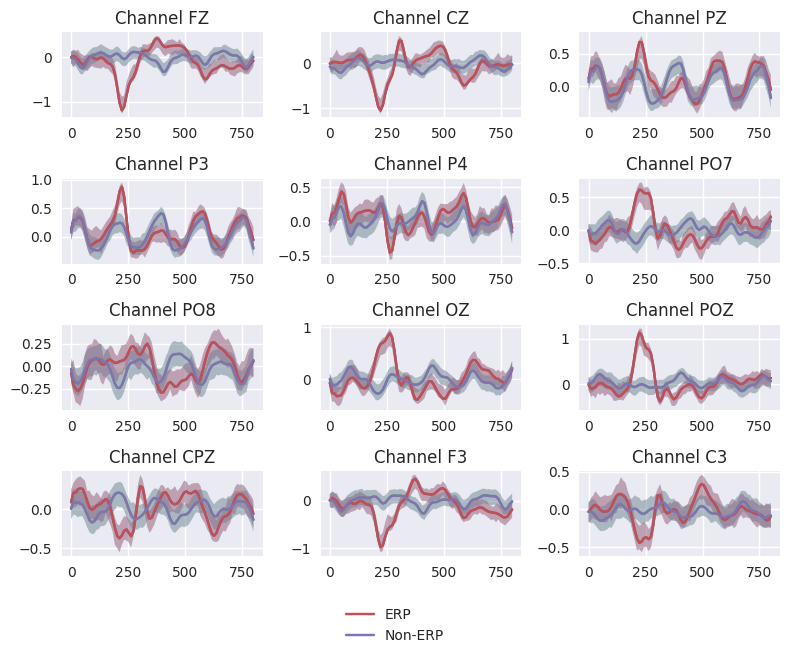

In [46]:
# Plot ERPs
print('> Plot ERPs in all channels')
with plt.style.context('seaborn-v0_8'):
    fig, axs = plt.subplots(4, 3, figsize=(8, 6))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Channel {subj_dataset.channel_set.l_cha[i]}')
        plot_data = erp_plots.plot_erp(
            erp_epochs=trials_erp_epochs,
            noerp_epochs=trials_noerp_epochs,
            channel=i,                  # Index of the desired channel
            window=[0, 800],            # Window to be extracted in ms
            error_measure="C55",        # 55% confidence interval
            axes=ax)
        t = np.linspace(0, 800, plot_data["trials_erp_mean"].shape[0])
        ax.plot(t, plot_data["trials_erp_mean"], label="ERP")
        ax.fill_between(t, plot_data["trials_erp_dev"][0],
                        plot_data["trials_erp_dev"][1],
                        alpha=0.3)
        ax.plot(t, plot_data["trials_noerp_mean"], label="Non-ERP")
        ax.fill_between(t, plot_data["trials_noerp_dev"][0],
                        plot_data["trials_noerp_dev"][1],
                        alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(0, -0.1, 1, 1))
plt.tight_layout()
plt.show()

## Calibration stage
The next step is to train a model using the calibration recordings. In this
process, signal processing follows the reference processing based on regularized
linear discriminant analysis (rLDA)

We'll only use the training recordings. Then we create and fit the model.

<div class="alert alert-block alert-info">
For more detailed information on this reference processing approach, please
refer to references [1, 2]

In [25]:
# Create calibration dataset
print('> Creating calibration dataset...')
file_pattern = '*TRAIN*.rcp.bson'
training_files = glob.glob('%s/%s' % (folder, file_pattern))
print('   - Detected %i training recordings' % len(training_files))
train_dataset = erp_spellers.ERPSpellerDataset(
    channel_set=rec.eeg.channel_set,
    fs=256,
    biosignal_att_key='eeg',
    experiment_att_key='erpspellerdata',
    experiment_mode='train')
train_dataset.add_recordings(training_files)

# Create model
print('> Create rLDA model')
cmd_model = erp_spellers.CMDModelRLDA()
cmd_model.configure()
cmd_model.build()

# Fit model
print('> Fit model with the training dataset')
cmd_fit_results = cmd_model.fit_dataset(train_dataset,
                                        validation_split=0.2,
                                        batch_size=512)

# Print fit results
print_acc_per_seq(cmd_fit_results['spell_acc_per_seq'],
                  title='Train accuracy per number of '
                        'sequences of stimulation:')

> Creating calibration dataset...
   - Detected 3 training recordings
> Create rLDA model
> Fit model with the training dataset


Extracting features: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s]



Train accuracy per number of sequences of stimulation:

                          1      2      3      4      5    6    7    8    9    10    11    12    13    14    15
--------------------  -----  -----  -----  -----  -----  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----
Command decoding acc  55.56  72.22  88.89  94.44  94.44  100  100  100  100   100   100   100   100   100   100


## Decoding stage

Once the model is trained, we are ready to perform online decoding and evaluate
its performance.

First, we need to load the test recordings along with the true labels, which
represent the commands the user was focusing on during this stage.

Take into account that these recordings were also recorded in train mode to
facilitate the assesment of the model.

> Loading test data...
   - Detected 2 test recordings
> Creating test dataset...
> Test model with the test dataset


Extracting features: 100%|██████████| 2/2 [00:00<00:00, 25.02it/s]



Test accuracy per number of sequences of stimulation:

                          1      2      3      4      5      6      7      8    9    10    11    12    13    14    15
--------------------  -----  -----  -----  -----  -----  -----  -----  -----  ---  ----  ----  ----  ----  ----  ----
Command decoding acc  33.33  41.67  83.33  83.33  83.33  91.67  91.67  91.67  100   100   100   100   100   100   100


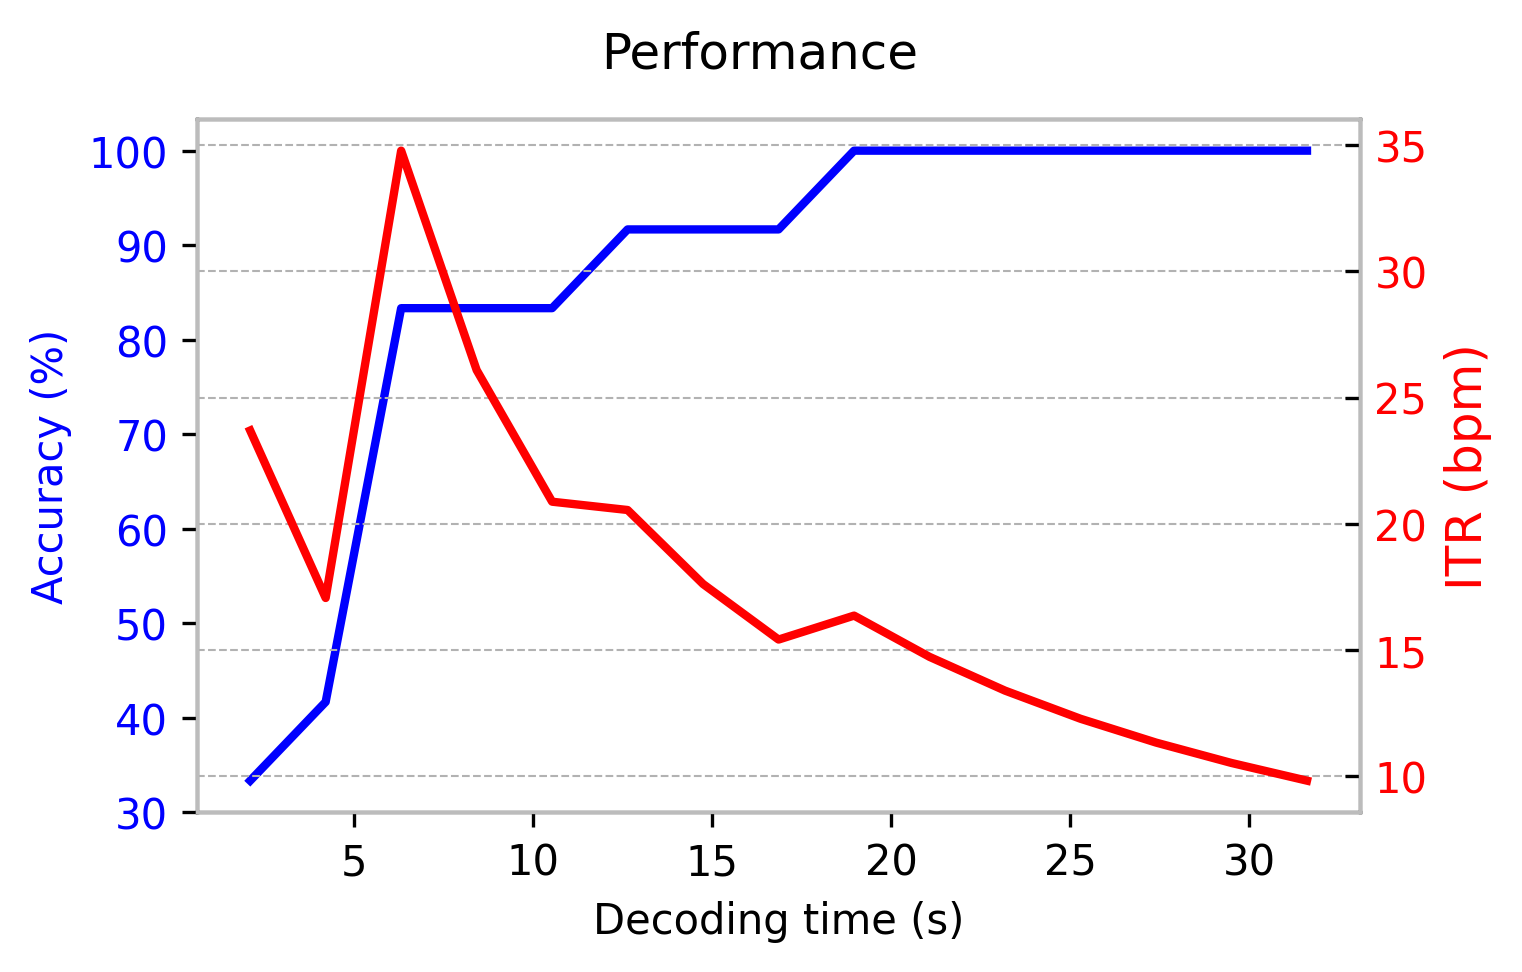

In [44]:
# Find test data
print('> Loading test data...')
file_pattern = '*TEST*.rcp.bson'
test_files = glob.glob('%s/%s' % (folder, file_pattern))
print('   - Detected %i test recordings' % len(test_files))

# Create test dataset
print('> Creating test dataset...')
test_dataset = erp_spellers.ERPSpellerDataset(
    channel_set=rec.eeg.channel_set,
    fs=256,
    biosignal_att_key='eeg',
    experiment_att_key='erpspellerdata',
    experiment_mode='train')
test_dataset.add_recordings(test_files)

# Test model
print('> Test model with the test dataset')
# Preprocessing
signal = cmd_model.get_inst('prep_method').fit_transform_dataset(
    test_dataset, test_dataset.fs)
# Extract features
x, x_info = cmd_model.get_inst('ext_method').transform_dataset(test_dataset)
# Classification
y_pred = cmd_model.get_inst('clf_method').predict_proba(x)[:, 1]
# Command decoding
spell_result, spell_result_per_seq, __ = erp_spellers.decode_commands(
    scores=y_pred,
    paradigm_conf=x_info['paradigm_conf'],
    run_idx=x_info['run_idx'],
    trial_idx=x_info['trial_idx'],
    matrix_idx=x_info['matrix_idx'],
    level_idx=x_info['level_idx'],
    unit_idx=x_info['unit_idx'],
    sequence_idx=x_info['sequence_idx'],
    group_idx=x_info['group_idx'],
    batch_idx=x_info['batch_idx']
)
# Assessment (possible because the recordings were recorded in train mode
# (i.e. we have the true labels)
spell_acc_per_seq = erp_spellers.command_decoding_accuracy_per_seq(
    spell_result_per_seq,
    x_info['spell_target']
)
# ITR
rec_info = test_dataset.recordings[0].erpspellerdata
ind = np.where(np.array(rec_info.trial_idx) == 0)[0]
approx_seq_dur = (rec_info.onsets[ind[-1]] - rec_info.onsets[ind[0]])/15
itrs = list()
time = list()
for i in range(x_info['sequence_idx'].max()+1):
    duration = approx_seq_dur * (i + 1)
    selections_per_min = 60 / duration
    curr_itr = itr(accuracy=spell_acc_per_seq[i],
                   n_commands=36,
                   selections_per_min=selections_per_min)
    itrs.append(curr_itr)
    time.append(duration)

# Print test results
print_acc_per_seq(
    spell_acc_per_seq,
    title='Test accuracy per number of sequences of stimulation:')

# Plot
fig = plt.figure(figsize=(5, 3), dpi=300)
ax = fig.add_subplot(111)
with plt.style.context('bmh'):
    ax.plot(time, spell_acc_per_seq*100, color='b')
    ax.set_xlabel('Decoding time (s)')
    ax.set_ylabel('Accuracy (%)', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax2 = ax.twinx()
    ax2.plot(time, itrs, color='r')
    ax2.set_ylabel("ITR (bpm)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
plt.suptitle('Performance')
plt.show()

## References

Check the following references for extended information about some of the
aspects of this tutorial:

1. *Santamaría-Vázquez, E., Martínez-Cagigal, V., Vaquerizo-Villar, F., &
Hornero, R. (2020). EEG-Inception: A Novel Deep Convolutional Neural Network for
Assistive ERP-based Brain-Computer Interfaces. IEEE Transactions on Neural
Systems and Rehabilitation Engineering. DOI: __[https://doi.org/10.1109/TNSRE.2020.3048106](https://doi.org/10.1109/TNSRE.2020.3048106)__*
2. *Santamaría-Vázquez, E., Martínez-Cagigal, V., Gomez-Pilar, J., & Hornero,
R. (2019). Asynchronous Control of ERP-Based BCI Spellers Using Steady-State
Visual Evoked Potentials Elicited by Peripheral Stimuli. IEEE Transactions on
Neural Systems and Rehabilitation Engineering, 27(9), 1883-1892. DOI: __[https://doi.org/10.1109/tnsre.2019.2934645](https://doi.org/10.1109/tnsre.2019.2934645)__*

